#minimum Redundancy - Maximum Relevance
Made by: Wilfredo Aaron Sosa Ramos

In [1]:
!pip install -q mrmr_selection

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


##1. Pandas example

In [2]:
# create some pandas data
import pandas as pd
from sklearn.datasets import make_classification
X, y = make_classification(n_samples = 1000, n_features = 50, n_informative = 10, n_redundant = 40)
X = pd.DataFrame(X)
y = pd.Series(y)

# select top 10 features using mRMR
from mrmr import mrmr_classif
selected_features = mrmr_classif(X=X, y=y, K=10)

100%|██████████| 10/10 [00:00<00:00, 31.37it/s]


In [3]:
selected_features

[46, 19, 38, 32, 21, 20, 42, 30, 13, 36]

##2. Polars example

In [8]:
import polars as pl
data = [(1.0, 1.0, 1.0, 7.0, 1.5, -2.3),
        (2.0, 3.0, 2.0, 7.0, 8.5, 6.7),
        (2.0, 4.2, 3.0, 7.0, -2.3, 4.4),
        (3.0, 4.0, 3.0, 7.0, 0.0, 0.0),
        (4.0, 5.0, 4.0, 7.0, 12.1, -5.2)]
columns = ["target", "values", "feature", "constant", "other_feature", "another_feature"]
df_polars = pl.DataFrame(data=data, schema=columns)

# select top 2 features using mRMR
import mrmr

# Modify the correlation function within the mrmr library
def correlation(target_column, features, df):
    out = pd.Series(features, index=features).apply(
        lambda feature: df
            .filter(~(pl.col(feature).is_null()) & ~(pl.col(target_column).is_null()))
            .select(pl.corr(feature, target_column))[0, 0]  # Use pl.corr instead of pl.pearson_corr
    ).astype(float).fillna(0.0)
    return out

# Monkey patch the correlation function in the mrmr.polars module
mrmr.polars.correlation = correlation

selected_features = mrmr.polars.mrmr_regression(df=df_polars, target_column="target", K=2)

100%|██████████| 2/2 [00:00<00:00, 232.46it/s]


In [9]:
selected_features

['feature', 'values']

##3. Spark example

In [10]:
# create some spark data
import pyspark
session = pyspark.sql.SparkSession(pyspark.context.SparkContext())
data = [(1.0, 1.0, 1.0, 7.0, 1.5, -2.3),
        (2.0, float('NaN'), 2.0, 7.0, 8.5, 6.7),
        (2.0, float('NaN'), 3.0, 7.0, -2.3, 4.4),
        (3.0, 4.0, 3.0, 7.0, 0.0, 0.0),
        (4.0, 5.0, 4.0, 7.0, 12.1, -5.2)]
columns = ["target", "some_null", "feature", "constant", "other_feature", "another_feature"]
df_spark = session.createDataFrame(data=data, schema=columns)

# select top 2 features using mRMR
import mrmr
selected_features = mrmr.spark.mrmr_regression(df=df_spark, target_column="target", K=2)

100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


In [11]:
selected_features

['some_null', 'feature']

100%|██████████| 10/10 [00:00<00:00, 37.88it/s]


Classification Results:
Model: Bagging (Linear Regression), Accuracy: 81.7340, F1 Score: 7.0583
Model: Bagging (Logistic Regression), Accuracy: 0.8333, F1 Score: 0.8333
Model: Decision Tree, Accuracy: 0.8333, F1 Score: 0.8344
Model: Gradient Boosting, Accuracy: 984.3023, F1 Score: 24.2920
Model: Gradient Boosting, Accuracy: 0.8867, F1 Score: 0.8859
Model: K-Nearest Neighbors, Accuracy: 0.9233, F1 Score: 0.9236
Model: Lasso, Accuracy: 83.9137, F1 Score: 7.1968
Model: Linear Regression, Accuracy: 81.4092, F1 Score: 7.0434
Model: Logistic Regression, Accuracy: 0.8367, F1 Score: 0.8350
Model: Random Forest, Accuracy: 0.9067, F1 Score: 0.9085
Model: Random Forest, Accuracy: 2387.8211, F1 Score: 36.8941
Model: Ridge, Accuracy: 81.3092, F1 Score: 7.0450
Model: SVM, Accuracy: 0.9167, F1 Score: 0.9186
Model: SVR, Accuracy: 20802.3093, F1 Score: 113.7902
Model: Stacking, Accuracy: 0.9233, F1 Score: 0.9251
Model: Stacking, Accuracy: 80.4320, F1 Score: 7.0080

Regression Results:
Model: Bagging (L

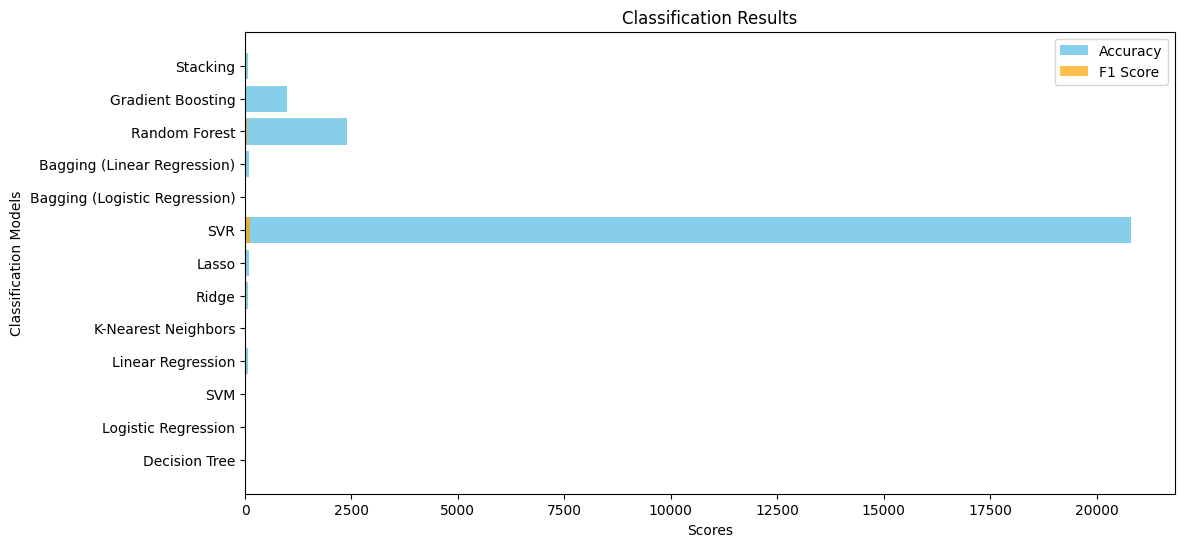

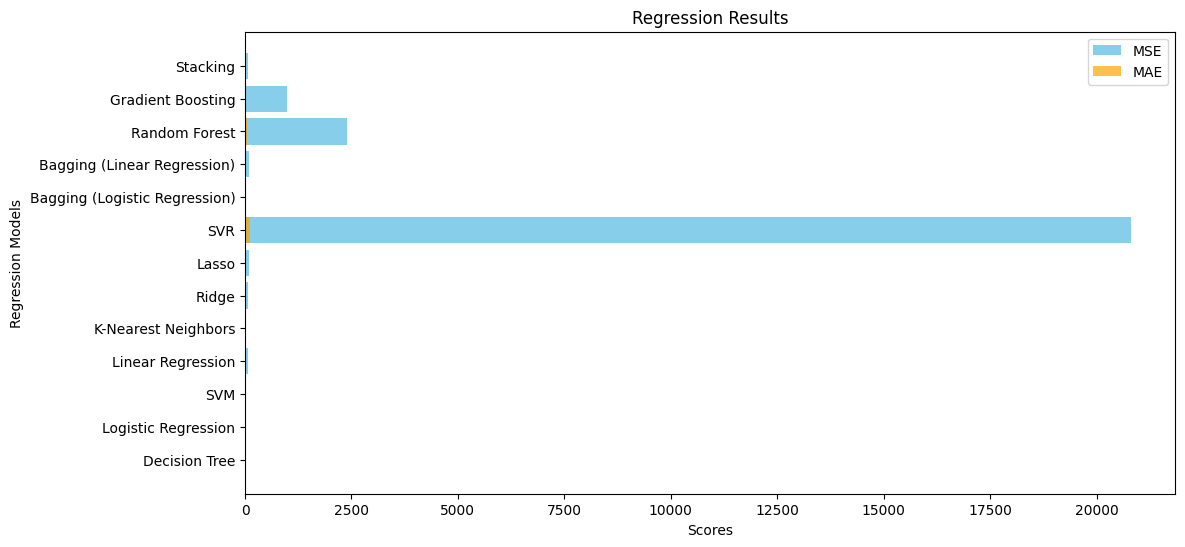

In [14]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification, make_regression
from mrmr import mrmr_classif, mrmr_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    GradientBoostingClassifier, GradientBoostingRegressor,
    BaggingClassifier, BaggingRegressor,
    StackingClassifier, StackingRegressor
)
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import concurrent.futures

# Generate datasets
X_class, y_class = make_classification(n_samples=1000, n_features=50, n_informative=10, n_redundant=40, random_state=42)
X_regr, y_regr = make_regression(n_samples=1000, n_features=50, n_informative=10, noise=0.5, random_state=42)

# Convert to DataFrame/Series
X_class = pd.DataFrame(X_class)
y_class = pd.Series(y_class)
X_regr = pd.DataFrame(X_regr)
y_regr = pd.Series(y_regr)

# Feature selection using mRMR
selected_features_class = mrmr_classif(X=X_class, y=y_class, K=10)
selected_features_regr = mrmr_regression(X=X_regr, y=y_regr, K=10)

# Subset the datasets
X_class = X_class[selected_features_class]
X_regr = X_regr[selected_features_regr]

# Split datasets
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42)
X_regr_train, X_regr_test, y_regr_train, y_regr_test = train_test_split(X_regr, y_regr, test_size=0.3, random_state=42)

# Define base models
base_class_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

base_reg_models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Random Forest": RandomForestRegressor(),
    "SVR": SVR(),
    "Gradient Boosting": GradientBoostingRegressor()
}

# Add ensemble methods
class_models = {
    **base_class_models,
    "Bagging (Logistic Regression)": BaggingClassifier(estimator=LogisticRegression(max_iter=1000)),
    "Stacking": StackingClassifier(estimators=list(base_class_models.items()), final_estimator=LogisticRegression())
}

reg_models = {
    **base_reg_models,
    "Bagging (Linear Regression)": BaggingRegressor(estimator=LinearRegression()),
    "Stacking": StackingRegressor(estimators=list(base_reg_models.items()), final_estimator=Ridge())
}

# Function to train and evaluate classification models
def train_classification(model_name, model):
    model.fit(X_class_train, y_class_train)
    y_pred = model.predict(X_class_test)
    accuracy = accuracy_score(y_class_test, y_pred)
    f1 = f1_score(y_class_test, y_pred)
    return model_name, accuracy, f1

# Function to train and evaluate regression models
def train_regression(model_name, model):
    model.fit(X_regr_train, y_regr_train)
    y_pred = model.predict(X_regr_test)
    mse = mean_squared_error(y_regr_test, y_pred)
    mae = mean_absolute_error(y_regr_test, y_pred)
    return model_name, mse, mae

# Multithreading for model training
results = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for model_name, model in class_models.items():
        futures.append(executor.submit(train_classification, model_name, model))
    for model_name, model in reg_models.items():
        futures.append(executor.submit(train_regression, model_name, model))

    for future in concurrent.futures.as_completed(futures):
        results.append(future.result())

# Sequentially display results
classification_results = [r for r in results if len(r) == 3 and isinstance(r[1], float) and isinstance(r[2], float)]
regression_results = [r for r in results if len(r) == 3 and isinstance(r[1], float) and not isinstance(r[2], str)]

# Print classification results
print("Classification Results:")
for model_name, accuracy, f1 in sorted(classification_results, key=lambda x: x[0]):
    print(f"Model: {model_name}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

# Print regression results
print("\nRegression Results:")
for model_name, mse, mae in sorted(regression_results, key=lambda x: x[0]):
    print(f"Model: {model_name}, MSE: {mse:.4f}, MAE: {mae:.4f}")

# Plot classification results
class_model_names = [r[0] for r in classification_results]
class_accuracies = [r[1] for r in classification_results]
class_f1_scores = [r[2] for r in classification_results]

plt.figure(figsize=(12, 6))
plt.barh(class_model_names, class_accuracies, color='skyblue', label="Accuracy")
plt.barh(class_model_names, class_f1_scores, color='orange', label="F1 Score", alpha=0.7)
plt.xlabel("Scores")
plt.ylabel("Classification Models")
plt.title("Classification Results")
plt.legend()
plt.show()

# Plot regression results
reg_model_names = [r[0] for r in regression_results]
reg_mses = [r[1] for r in regression_results]
reg_maes = [r[2] for r in regression_results]

plt.figure(figsize=(12, 6))
plt.barh(reg_model_names, reg_mses, color='skyblue', label="MSE")
plt.barh(reg_model_names, reg_maes, color='orange', label="MAE", alpha=0.7)
plt.xlabel("Scores")
plt.ylabel("Regression Models")
plt.title("Regression Results")
plt.legend()
plt.show()


Classification Results:
Model: Bagging (Linear Regression), Accuracy: 0.5318, F1 Score: 0.5273
Model: Bagging (Logistic Regression), Accuracy: 1.0000, F1 Score: 1.0000
Model: Decision Tree, Accuracy: 1.0000, F1 Score: 1.0000
Model: Gradient Boosting, Accuracy: 1.0000, F1 Score: 1.0000
Model: Gradient Boosting, Accuracy: 0.2884, F1 Score: 0.3714
Model: K-Nearest Neighbors, Accuracy: 1.0000, F1 Score: 1.0000
Model: Lasso, Accuracy: 0.9345, F1 Score: 0.7610
Model: Linear Regression, Accuracy: 0.5306, F1 Score: 0.5272
Model: Logistic Regression, Accuracy: 1.0000, F1 Score: 1.0000
Model: Random Forest, Accuracy: 1.0000, F1 Score: 1.0000
Model: Random Forest, Accuracy: 0.2540, F1 Score: 0.3298
Model: Ridge, Accuracy: 0.5305, F1 Score: 0.5273
Model: SVM, Accuracy: 1.0000, F1 Score: 1.0000
Model: SVR, Accuracy: 1.3490, F1 Score: 0.8665
Model: Stacking, Accuracy: 1.0000, F1 Score: 1.0000
Model: Stacking, Accuracy: 0.2479, F1 Score: 0.3308

Regression Results:
Model: Bagging (Linear Regression),

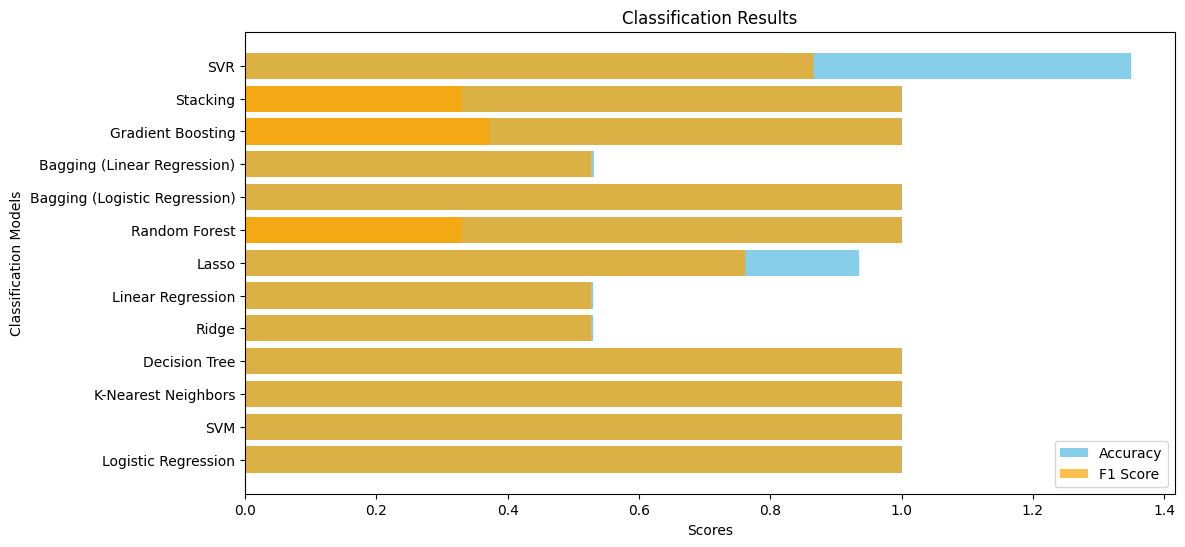

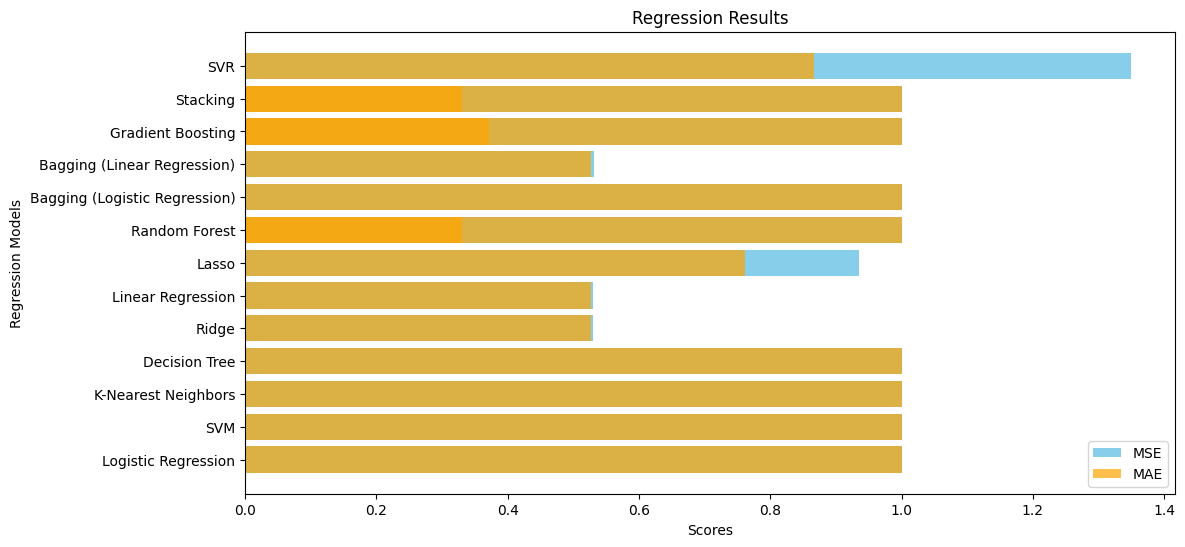

In [16]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    GradientBoostingClassifier, GradientBoostingRegressor,
    BaggingClassifier, BaggingRegressor,
    StackingClassifier, StackingRegressor
)
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import concurrent.futures

# Load Classification Dataset: Iris
iris = load_iris(as_frame=True)
X_class = iris.data
y_class = iris.target

# Load Regression Dataset: California Housing
california = fetch_california_housing(as_frame=True)
X_regr = california.data
y_regr = california.target

# Split datasets
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42)
X_regr_train, X_regr_test, y_regr_train, y_regr_test = train_test_split(X_regr, y_regr, test_size=0.3, random_state=42)

# Define base models
base_class_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

base_reg_models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Random Forest": RandomForestRegressor(),
    "SVR": SVR(),
    "Gradient Boosting": GradientBoostingRegressor()
}

# Add ensemble methods
class_models = {
    **base_class_models,
    "Bagging (Logistic Regression)": BaggingClassifier(estimator=LogisticRegression(max_iter=1000)),
    "Stacking": StackingClassifier(estimators=list(base_class_models.items()), final_estimator=LogisticRegression())
}

reg_models = {
    **base_reg_models,
    "Bagging (Linear Regression)": BaggingRegressor(estimator=LinearRegression()),
    "Stacking": StackingRegressor(estimators=list(base_reg_models.items()), final_estimator=Ridge())
}

# Function to train and evaluate classification models
def train_classification(model_name, model):
    model.fit(X_class_train, y_class_train)
    y_pred = model.predict(X_class_test)
    accuracy = accuracy_score(y_class_test, y_pred)
    f1 = f1_score(y_class_test, y_pred, average='weighted')  # Weighted for multiclass
    return model_name, accuracy, f1

# Function to train and evaluate regression models
def train_regression(model_name, model):
    model.fit(X_regr_train, y_regr_train)
    y_pred = model.predict(X_regr_test)
    mse = mean_squared_error(y_regr_test, y_pred)
    mae = mean_absolute_error(y_regr_test, y_pred)
    return model_name, mse, mae

# Multithreading for model training
results = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for model_name, model in class_models.items():
        futures.append(executor.submit(train_classification, model_name, model))
    for model_name, model in reg_models.items():
        futures.append(executor.submit(train_regression, model_name, model))

    for future in concurrent.futures.as_completed(futures):
        results.append(future.result())

# Sequentially display results
classification_results = [r for r in results if len(r) == 3 and isinstance(r[1], float) and isinstance(r[2], float)]
regression_results = [r for r in results if len(r) == 3 and isinstance(r[1], float) and not isinstance(r[2], str)]

# Print classification results
print("Classification Results:")
for model_name, accuracy, f1 in sorted(classification_results, key=lambda x: x[0]):
    print(f"Model: {model_name}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

# Print regression results
print("\nRegression Results:")
for model_name, mse, mae in sorted(regression_results, key=lambda x: x[0]):
    print(f"Model: {model_name}, MSE: {mse:.4f}, MAE: {mae:.4f}")

# Plot classification results
class_model_names = [r[0] for r in classification_results]
class_accuracies = [r[1] for r in classification_results]
class_f1_scores = [r[2] for r in classification_results]

plt.figure(figsize=(12, 6))
plt.barh(class_model_names, class_accuracies, color='skyblue', label="Accuracy")
plt.barh(class_model_names, class_f1_scores, color='orange', label="F1 Score", alpha=0.7)
plt.xlabel("Scores")
plt.ylabel("Classification Models")
plt.title("Classification Results")
plt.legend()
plt.show()

# Plot regression results
reg_model_names = [r[0] for r in regression_results]
reg_mses = [r[1] for r in regression_results]
reg_maes = [r[2] for r in regression_results]

plt.figure(figsize=(12, 6))
plt.barh(reg_model_names, reg_mses, color='skyblue', label="MSE")
plt.barh(reg_model_names, reg_maes, color='orange', label="MAE", alpha=0.7)
plt.xlabel("Scores")
plt.ylabel("Regression Models")
plt.title("Regression Results")
plt.legend()
plt.show()


100%|██████████| 8/8 [00:00<00:00, 59.86it/s]


Classification Results:
Model: Bagging (Linear Regression), Accuracy: 0.5273, F1 Score: 0.5243
Model: Bagging (Logistic Regression), Accuracy: 1.0000, F1 Score: 1.0000
Model: Decision Tree, Accuracy: 1.0000, F1 Score: 1.0000
Model: Gradient Boosting, Accuracy: 1.0000, F1 Score: 1.0000
Model: Gradient Boosting, Accuracy: 0.2883, F1 Score: 0.3714
Model: K-Nearest Neighbors, Accuracy: 1.0000, F1 Score: 1.0000
Model: Lasso, Accuracy: 0.9345, F1 Score: 0.7610
Model: Linear Regression, Accuracy: 0.5306, F1 Score: 0.5272
Model: Logistic Regression, Accuracy: 1.0000, F1 Score: 1.0000
Model: Random Forest, Accuracy: 1.0000, F1 Score: 1.0000
Model: Random Forest, Accuracy: 0.2541, F1 Score: 0.3305
Model: Ridge, Accuracy: 0.5305, F1 Score: 0.5273
Model: SVM, Accuracy: 1.0000, F1 Score: 1.0000
Model: SVR, Accuracy: 1.3490, F1 Score: 0.8665
Model: Stacking, Accuracy: 1.0000, F1 Score: 1.0000
Model: Stacking, Accuracy: 0.2503, F1 Score: 0.3321

Regression Results:
Model: Bagging (Linear Regression),

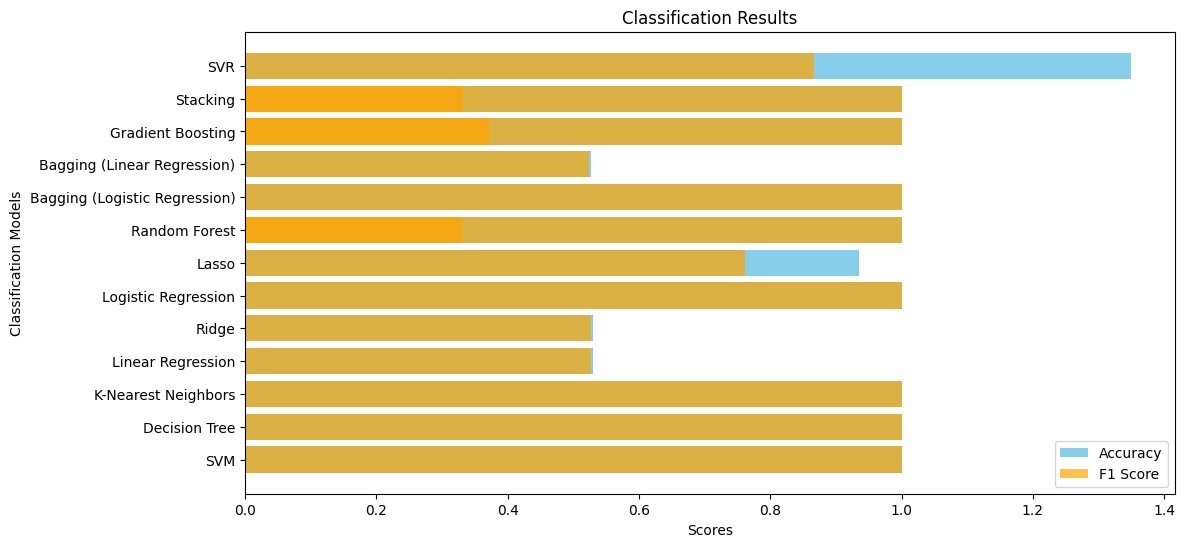

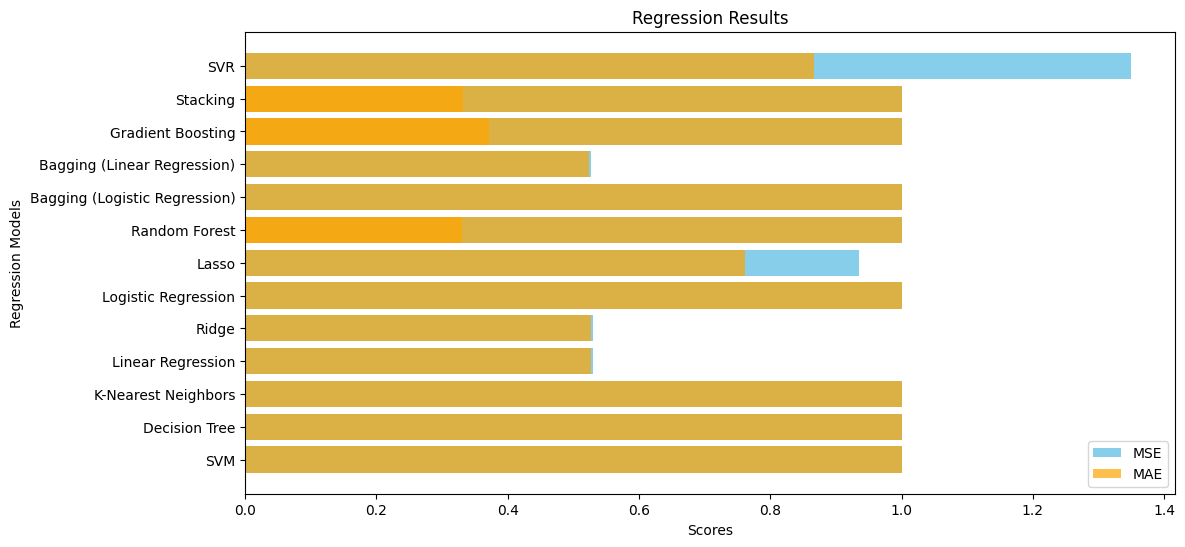

In [17]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    GradientBoostingClassifier, GradientBoostingRegressor,
    BaggingClassifier, BaggingRegressor,
    StackingClassifier, StackingRegressor
)
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import concurrent.futures
from mrmr import mrmr_classif, mrmr_regression

# Load Classification Dataset: Iris
iris = load_iris(as_frame=True)
X_class = iris.data
y_class = iris.target

# Load Regression Dataset: California Housing
california = fetch_california_housing(as_frame=True)
X_regr = california.data
y_regr = california.target

# Apply mRMR feature selection
selected_features_class = mrmr_classif(X=X_class, y=y_class, K=10)
selected_features_regr = mrmr_regression(X=X_regr, y=y_regr, K=10)

# Subset the datasets with selected features
X_class = X_class[selected_features_class]
X_regr = X_regr[selected_features_regr]

# Split datasets
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42)
X_regr_train, X_regr_test, y_regr_train, y_regr_test = train_test_split(X_regr, y_regr, test_size=0.3, random_state=42)

# Define base models
base_class_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

base_reg_models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Random Forest": RandomForestRegressor(),
    "SVR": SVR(),
    "Gradient Boosting": GradientBoostingRegressor()
}

# Add ensemble methods
class_models = {
    **base_class_models,
    "Bagging (Logistic Regression)": BaggingClassifier(estimator=LogisticRegression(max_iter=1000)),
    "Stacking": StackingClassifier(estimators=list(base_class_models.items()), final_estimator=LogisticRegression())
}

reg_models = {
    **base_reg_models,
    "Bagging (Linear Regression)": BaggingRegressor(estimator=LinearRegression()),
    "Stacking": StackingRegressor(estimators=list(base_reg_models.items()), final_estimator=Ridge())
}

# Function to train and evaluate classification models
def train_classification(model_name, model):
    model.fit(X_class_train, y_class_train)
    y_pred = model.predict(X_class_test)
    accuracy = accuracy_score(y_class_test, y_pred)
    f1 = f1_score(y_class_test, y_pred, average='weighted')  # Weighted for multiclass
    return model_name, accuracy, f1

# Function to train and evaluate regression models
def train_regression(model_name, model):
    model.fit(X_regr_train, y_regr_train)
    y_pred = model.predict(X_regr_test)
    mse = mean_squared_error(y_regr_test, y_pred)
    mae = mean_absolute_error(y_regr_test, y_pred)
    return model_name, mse, mae

# Multithreading for model training
results = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for model_name, model in class_models.items():
        futures.append(executor.submit(train_classification, model_name, model))
    for model_name, model in reg_models.items():
        futures.append(executor.submit(train_regression, model_name, model))

    for future in concurrent.futures.as_completed(futures):
        results.append(future.result())

# Sequentially display results
classification_results = [r for r in results if len(r) == 3 and isinstance(r[1], float) and isinstance(r[2], float)]
regression_results = [r for r in results if len(r) == 3 and isinstance(r[1], float) and not isinstance(r[2], str)]

# Print classification results
print("Classification Results:")
for model_name, accuracy, f1 in sorted(classification_results, key=lambda x: x[0]):
    print(f"Model: {model_name}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

# Print regression results
print("\nRegression Results:")
for model_name, mse, mae in sorted(regression_results, key=lambda x: x[0]):
    print(f"Model: {model_name}, MSE: {mse:.4f}, MAE: {mae:.4f}")

# Plot classification results
class_model_names = [r[0] for r in classification_results]
class_accuracies = [r[1] for r in classification_results]
class_f1_scores = [r[2] for r in classification_results]

plt.figure(figsize=(12, 6))
plt.barh(class_model_names, class_accuracies, color='skyblue', label="Accuracy")
plt.barh(class_model_names, class_f1_scores, color='orange', label="F1 Score", alpha=0.7)
plt.xlabel("Scores")
plt.ylabel("Classification Models")
plt.title("Classification Results")
plt.legend()
plt.show()

# Plot regression results
reg_model_names = [r[0] for r in regression_results]
reg_mses = [r[1] for r in regression_results]
reg_maes = [r[2] for r in regression_results]

plt.figure(figsize=(12, 6))
plt.barh(reg_model_names, reg_mses, color='skyblue', label="MSE")
plt.barh(reg_model_names, reg_maes, color='orange', label="MAE", alpha=0.7)
plt.xlabel("Scores")
plt.ylabel("Regression Models")
plt.title("Regression Results")
plt.legend()
plt.show()